## KNN Lazy learning method

### 1- Loading of data

In [2]:
import pandas as pd
try:
    diabetes_df = pd.read_csv('../preprocessing_scripts/Data_preprocessed_10000.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    diabetes_df = None
    print("File not found. Please check the file path.")

Dataset loaded successfully.


### 2- Visualize first columns

In [3]:
diabetes_df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,0.0,1.0,1.0,-1.071593,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,10.0,4.0,5.0
1,0.0,0.0,0.0,1.0,0.628607,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,3.0,1.0,0.0,13.0,5.0,4.0
2,0.0,1.0,1.0,1.0,-0.319133,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,5.0,0.0,1.0,8.0,6.0,6.0
3,0.0,0.0,1.0,1.0,0.017644,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,7.0,5.0,8.0
4,1.0,1.0,0.0,1.0,2.311887,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,4.0,30.0,10.0,1.0,1.0,6.0,6.0,3.0


### 3- Separate the features and target variable

In [4]:
# Let's separate Data from labels

X = diabetes_df.drop(['Diabetes_binary'], axis=1) # Data
y = diabetes_df['Diabetes_binary'].astype(int)# Label (Has diabtes (1) or not (0))

print(X.shape)
print(y.shape)

(9939, 21)
(9939,)


### 4 - Create train / test dataset

In [5]:
from sklearn.model_selection import train_test_split

(X_train, X_test,  y_train, y_test) = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

### 5 - Base f1 score


In [6]:
# Check what is the actual score without any performance tuning
# We are going to use k-fold cross validation
# We apply to all methods the same random state 42

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import sklearn.neighbors as nb
import numpy as np

# Ensures each fold maintains the same class distribution as the full dataset, 
# which is crucial for imbalanced classification tasks.
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle = True) 

# We are going to use the KNeighborsClassifier without any parameter tuning so,
# it will use 5 neighbors by default. Later we will use the GridSearchCV to find the best parameters
# for the KNeighborsClassifier
# We are going to use the f1 score as the metric for the model performance and slect "f1" for because the documentation states it's used for a binary target
# We use cross_val_score to evaluate the model by a score using cross-validation.

cv_scores = cross_val_score(nb.KNeighborsClassifier(), X=X_train,y=y_train, cv=cv, scoring='f1')  
np.mean(cv_scores)

np.float64(0.6983851086244882)

### 5- Detection of irrelevant features


In [7]:
# Let's build a pandas dataframe to work with columns

column_names = diabetes_df.drop('Diabetes_binary', axis=1).columns.tolist()

df=pd.DataFrame(data=X, columns=column_names)
df['Diabetes_binary']=y
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,0.0,1.0,1.0,-1.071593,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,4.0,0.0,0.0,0.0,0.0,10.0,4.0,5.0,1
1,0.0,0.0,1.0,0.628607,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,3.0,0.0,3.0,1.0,0.0,13.0,5.0,4.0,0
2,1.0,1.0,1.0,-0.319133,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,0.0,5.0,0.0,1.0,8.0,6.0,6.0,0
3,0.0,1.0,1.0,0.017644,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,3.0,0.0,5.0,0.0,1.0,7.0,5.0,8.0,0
4,1.0,0.0,1.0,2.311887,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,4.0,30.0,10.0,1.0,1.0,6.0,6.0,3.0,1


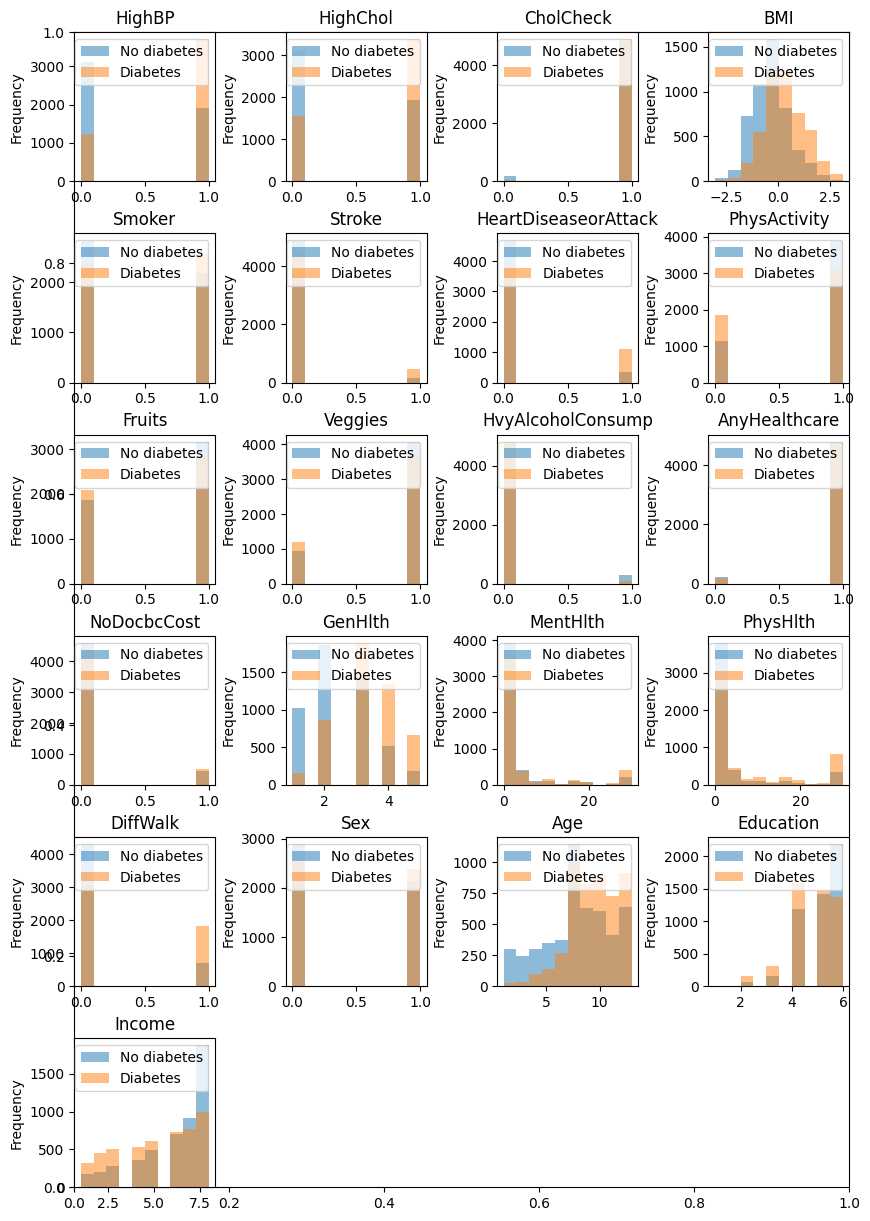

In [8]:
# Let's which features are more important i other words, which features help us to separate the data 
# in groups without supersititon.

# However, we will use sklearn to select the best k features. Fit that on whole data set and return only relevant columns. 

import matplotlib.pyplot as  plt

n = len(column_names)
cols = 4
rows = (n + cols - 1) // cols  


plt.subplots(figsize=(10, rows * 2.5))
plt.subplots_adjust(hspace=0.35,wspace=0.5)

for idx, col in enumerate(column_names):
    plt.subplot(rows, cols, idx + 1)

    df[df['Diabetes_binary'] == 0][col].plot.hist(
        bins=10, alpha=0.5, label='No diabetes'
    )

    df[df['Diabetes_binary'] == 1][col].plot.hist(
        bins=10, alpha=0.5, label='Diabetes'
    )
    plt.title(col)
    plt.legend()
plt.show()

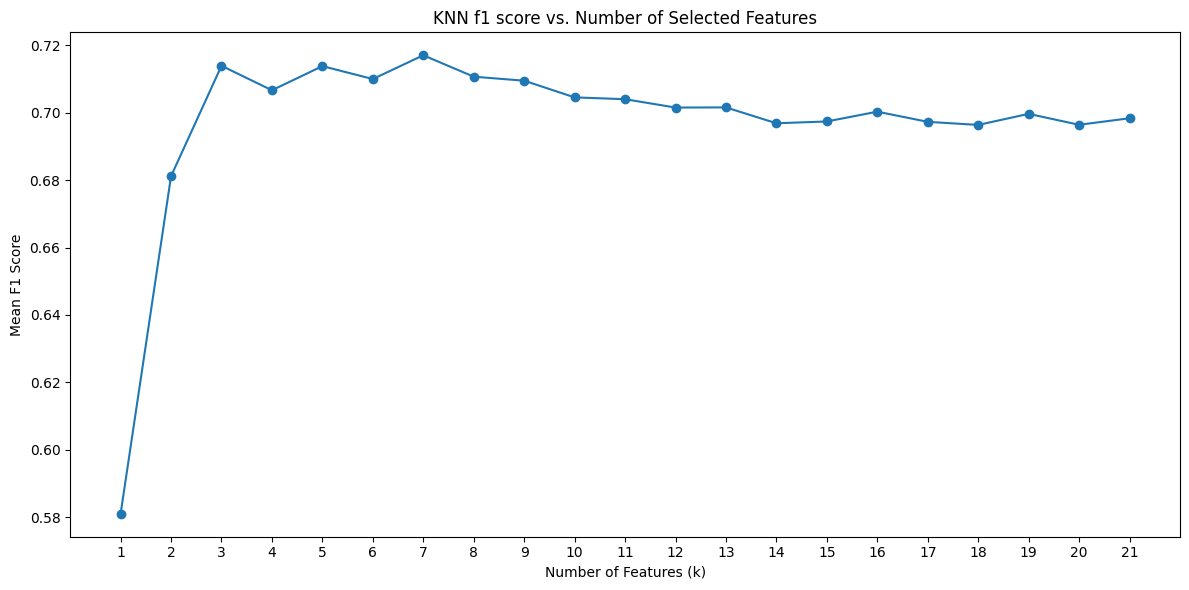

In [12]:
# Let's use SKLearn to select the best features
# We avoid to be fooled by irrelevant feature; what we want es to get a final dataset with only the relevant features
# We reduce noise and increase computational eficiency with less dimensions

# Improvement in accuracy

from sklearn.feature_selection import mutual_info_classif # Calculate the mutual information between each feature and the target
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline # Select the k best features based on the mutual information score

# We are going to iterate over different values k and see which one is the best
# Array to hold mean CV accuracy for each k
scores_by_k = np.zeros(len(column_names))

def mutual_info_fixed(X, y):
    return mutual_info_classif(X, y, random_state=42) 

for idx, feature in enumerate(column_names):
    k = idx + 1
    # Select the k best features by mutual information
    # Create a pipeline that first selects features, then applies KNN
    pipeline = Pipeline([
        ('selector', SelectKBest(mutual_info_fixed, k=k)),
        ('knn', KNeighborsClassifier())
    ])
    # Evaluate with stratified CV and KNN
    cv_scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='f1'
    )
    scores_by_k[idx] = np.mean(cv_scores)


plt.figure(figsize=(12, 6))
plt.plot(range(1, len(column_names) + 1), scores_by_k, marker='o')
plt.xticks(range(1, len(column_names) + 1))
plt.xlabel('Number of Features (k)')
plt.ylabel('Mean F1 Score')
plt.title('KNN f1 score vs. Number of Selected Features')
plt.tight_layout()
plt.show()

# We see that the f1 score stops increasing after the first 7 features.


### 5.1 - Compare if it's useful delete irrelevant features

In [13]:
# Statistical test to verify that removing irrelevant features improves performance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


print("=" * 60)
print("STATISTICAL COMPARISON: ALL FEATURES vs TOP 7 FEATURES")
print("=" * 60)


# 1. Train KNN with all features
knn_all = nb.KNeighborsClassifier()
knn_all.fit(X_train, y_train)
pred_all = knn_all.predict(X_test)

# 2. Train KNN with only the top 7 features
pipeline_selected = Pipeline([
    ('selector', SelectKBest(mutual_info_fixed, k=7)),
    ('knn', KNeighborsClassifier())
])
pipeline_selected.fit(X_train, y_train)
pred_selected = pipeline_selected.predict(X_test)

# 3. Compare F1-scores
from sklearn.metrics import f1_score
f1_all = f1_score(y_test, pred_all)
f1_selected = f1_score(y_test, pred_selected)

print(f"F1-score with ALL features ({X_train.shape[1]}): {f1_all:.4f}")
print(f"F1-score with TOP 7 features: {f1_selected:.4f}")
print(f"Improvement: {f1_selected - f1_all:.4f}")

# 4. McNemar's statistical test
from statsmodels.stats.contingency_tables import mcnemar

# Build the complete 2x2 contingency table
# [
#   [Both wrong, A wrong & B correct],
#   [A correct & B wrong, Both correct]
# ]

both_correct = np.sum((pred_all == y_test) & (pred_selected == y_test))
both_wrong = np.sum((pred_all != y_test) & (pred_selected != y_test))
only_all_correct = np.sum((pred_all == y_test) & (pred_selected != y_test))  # A correct, B wrong
only_selected_correct = np.sum((pred_all != y_test) & (pred_selected == y_test))  # A wrong, B correct

# McNemar contingency table
contingency_table = [[both_wrong, only_selected_correct],
                     [only_all_correct, both_correct]]

print(f"\n--- McNemar Test - Complete Analysis ---")
print(f"Contingency Table:")
print(f"                     Selected Model")
print(f"All Model      Wrong    Correct")
print(f"Wrong         {both_wrong:5d}    {only_selected_correct:5d}")
print(f"Correct       {only_all_correct:5d}    {both_correct:5d}")

# Verify totals
total_samples = len(y_test)
calculated_total = both_wrong + only_selected_correct + only_all_correct + both_correct
print(f"\nSample verification: {calculated_total}/{total_samples} samples accounted for")


print(f"\nDiscordant pairs:")
print(f"Cases where 'all features' wrong and 'top 7' correct: {only_selected_correct}")
print(f"Cases where 'all features' correct and 'top 7' wrong: {only_all_correct}")
print(f"Total discordant pairs: {only_selected_correct + only_all_correct}")

# Perform McNemar test with your preferred parameters
results_mcnemar = mcnemar(contingency_table, exact=False, correction=True)
print(f"\nMcNemar Test Results:")
print(f"Test statistic: {results_mcnemar.statistic}")
print(f"P-value: {results_mcnemar.pvalue:.5f}")

if results_mcnemar.pvalue < 0.05:
    print("✅ There IS a statistically significant difference")
    if f1_selected > f1_all:
        print("   → Top 7 features are SIGNIFICANTLY better")
        print("   Improvement in F1-score: {:.4f}".format(f1_selected - f1_all))
    else:
        print("   → All features are SIGNIFICANTLY better")
        print("   Improvement in F1-score: {:.4f}".format(f1_all - f1_selected))
else:
    print("❌ NO evidence of significant difference")

# Additional analysis
print(f"\n--- Performance Summary ---")
print(f"All features model accuracy: {np.mean(pred_all == y_test):.4f}")
print(f"Selected features model accuracy: {np.mean(pred_selected == y_test):.4f}")
print(f"Agreement between models: {np.mean(pred_all == pred_selected):.4f}")

# 5. Show which features were selected
selector = pipeline_selected.named_steps['selector']
feature_names = np.array(column_names)
selected_features = selector.get_support()
print(f"\n--- Selected features ---")
for i, feature in enumerate(feature_names[selected_features]):
    score = selector.scores_[selected_features][i]
    print(f"{i+1}. {feature} (score: {score:.3f})")

STATISTICAL COMPARISON: ALL FEATURES vs TOP 7 FEATURES
F1-score with ALL features (21): 0.6924
F1-score with TOP 7 features: 0.7244
Improvement: 0.0320

--- McNemar Test - Complete Analysis ---
Contingency Table:
                     Selected Model
All Model      Wrong    Correct
Wrong           555      378
Correct         289     1760

Sample verification: 2982/2982 samples accounted for

Discordant pairs:
Cases where 'all features' wrong and 'top 7' correct: 378
Cases where 'all features' correct and 'top 7' wrong: 289
Total discordant pairs: 667

McNemar Test Results:
Test statistic: 11.610194902548725
P-value: 0.00066
✅ There IS a statistically significant difference
   → Top 7 features are SIGNIFICANTLY better
   Improvement in F1-score: 0.0320

--- Performance Summary ---
All features model accuracy: 0.6871
Selected features model accuracy: 0.7170
Agreement between models: 0.7763

--- Selected features ---
1. HighBP (score: 0.081)
2. HighChol (score: 0.049)
3. BMI (score: 0.069)

### 6- Compare between base or smart KNN

Selected features: ['HighBP', 'HighChol', 'BMI', 'GenHlth', 'DiffWalk', 'Age', 'Income']


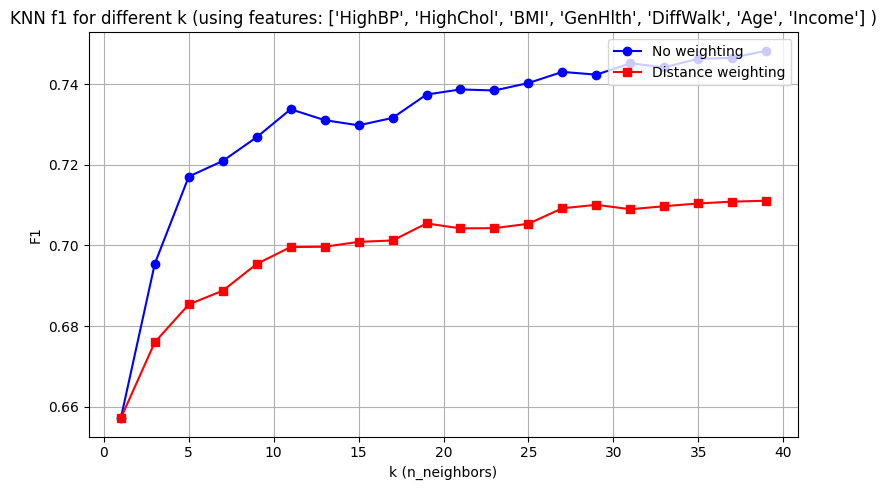

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

#We use fit_transform to fit the model and transform the data in one step

# Get the selected feature names
selector = SelectKBest(mutual_info_fixed, k=7).fit(X_train, y_train)
selected_features = [column_names[i] for i in selector.get_support(indices=True)]
print("Selected features:", selected_features)

# Base KNN classifier
scores_no_weight = []
for k in range(1, 40, 2):
    pipeline = Pipeline([
    ('selector', SelectKBest(mutual_info_fixed, k=7)),
    ('knn', KNeighborsClassifier(n_neighbors=k, weights='uniform'))
    ])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
    scores_no_weight.append(np.mean(cv_scores))

# SMART KNN classifier
scores_weight = []
for k in range(1, 40, 2):
    pipeline = Pipeline([
    ('selector', SelectKBest(mutual_info_fixed, k=7)),
    ('knn', KNeighborsClassifier(n_neighbors=k, weights='distance'))
    ])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')
    scores_weight.append(np.mean(cv_scores))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 40, 2), scores_no_weight, 'b-o', label='No weighting')
plt.plot(range(1, 40, 2), scores_weight,   'r-s', label='Distance weighting')
plt.xlabel('k (n_neighbors)')
plt.ylabel('F1')
plt.title('KNN f1 for different k (using features: {} )'.format(selected_features))
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

### 7- Find best parameters


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
#Even we saw that not using weights es better.
#Here we confirm it because comparing f1-scores doesn't take into account 
#variablity, doesn't sho statistic significance and depends o cv.

#We use GridSearchCV to find the best parameters for the KNeighborsClassifier

params = {
    'knn__n_neighbors': list(range(1,40,2)), 
    'knn__weights': ('distance','uniform'),
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': [1.25, 1.5, 1.75] # p is the power parameter for the Minkowski distance. Depending of value p it combines the euclidean and manhattan distances.
}

# It's interesting to use eclidian distance because it works well for standardized data.
# It's interesting to use manhattan distance because it is less sensitive to outliers.
# It's interesting to use minkowski distance because it is a generalization of both euclidean and manhattan distances.

pipeline = Pipeline([
    ('selector', SelectKBest(mutual_info_fixed, k=7)),
    ('knn', KNeighborsClassifier())
])

clf = GridSearchCV(pipeline, param_grid=params,cv=cv,n_jobs=-1, scoring='f1')

clf.fit(X_train, y_train) #GridSearchCV only uses fit method, not fit_transform because it does not transform the data

print("Best Params=",clf.best_params_, "F1-score=", clf.best_score_)

Best Params= {'knn__metric': 'minkowski', 'knn__n_neighbors': 39, 'knn__p': 1.75, 'knn__weights': 'uniform'} F1-score= 0.7491340595212778


### 8- Confusion matrix with real prediction


              precision    recall  f1-score   support

           0       0.79      0.69      0.73      1506
           1       0.72      0.81      0.76      1476

    accuracy                           0.75      2982
   macro avg       0.75      0.75      0.75      2982
weighted avg       0.75      0.75      0.75      2982


F1-score: 0.7604


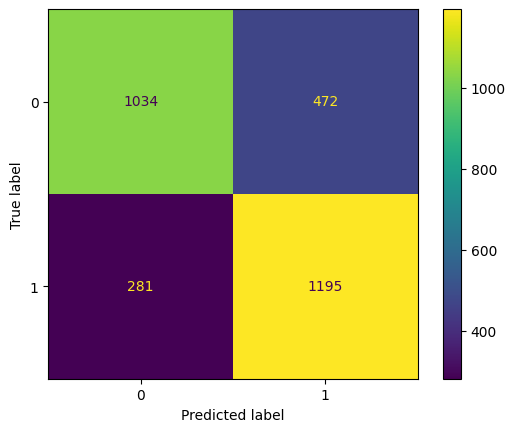

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, f1_score

pipeline = Pipeline([
    ('selector', SelectKBest(mutual_info_fixed, k=7)),
    ('knn', KNeighborsClassifier(n_neighbors=clf.best_params_['knn__n_neighbors'], 
                                weights=clf.best_params_['knn__weights'],
                                metric=clf.best_params_['knn__metric'],
                                p=clf.best_params_['knn__p']))
])

pipeline.fit(X_train, y_train) 

predicted = pipeline.predict(X_test) # Get the predictions, with pipeline we can use predict method directly because de X_test would be transformed

print(classification_report(y_test, predicted))  
ConfusionMatrixDisplay(confusion_matrix(y_test, predicted)).plot()

f1 = f1_score(y_test, predicted)
print(f"\nF1-score: {f1:.4f}")

### 9- See ROC curve to select best threshold


Best threshold (from training CV): 0.4103
F1-score on training (CV): 0.7596
F1-score on test with best threshold: 0.7663
AUC on test: 0.8149


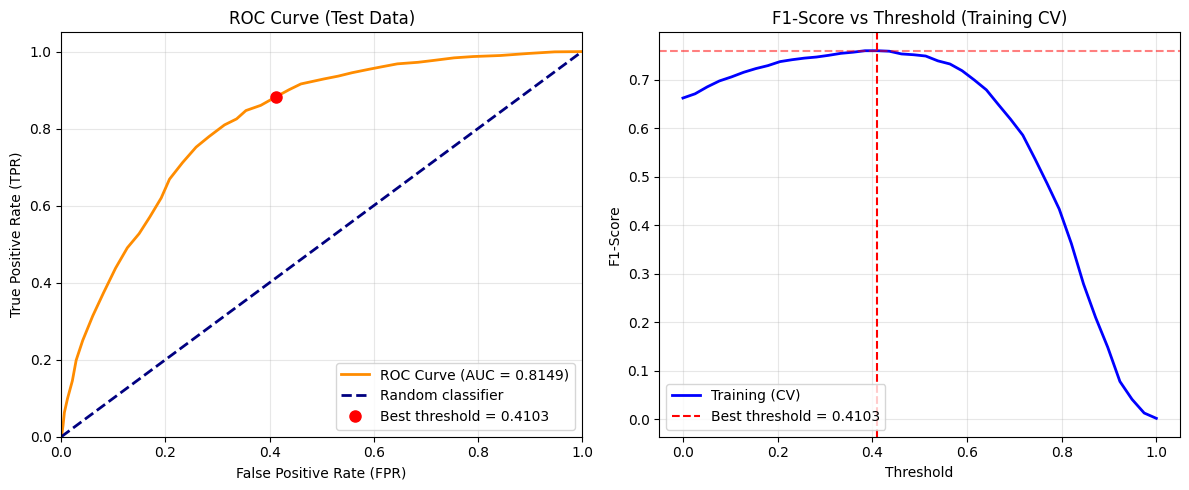

In [17]:
from sklearn.metrics import roc_curve, auc, f1_score
from sklearn.model_selection import cross_val_predict

pipeline = Pipeline([
    ('selector', SelectKBest(mutual_info_fixed, k=7)),
    ('knn', KNeighborsClassifier(n_neighbors=clf.best_params_['knn__n_neighbors'], 
                                weights=clf.best_params_['knn__weights'],
                                metric=clf.best_params_['knn__metric'],
                                p=clf.best_params_['knn__p']))
])

# Obtain cross-validation predictions on training data
y_train_proba = cross_val_predict(pipeline, X_train, y_train, cv=5, method='predict_proba')
y_train_scores = y_train_proba[:, 1]

# ROC curve using cross-validation predictions on training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_scores)

# Find the best threshold using F1-score on training data (cross-validation)
f1_scores_train = []
for threshold in thresholds_train:
    y_pred_threshold = (y_train_scores >= threshold).astype(int)
    f1_scores_train.append(f1_score(y_train, y_pred_threshold))

best_threshold_idx = np.argmax(f1_scores_train)
best_threshold = thresholds_train[best_threshold_idx]
best_f1_train = f1_scores_train[best_threshold_idx]

# Fit the pipeline with training data for test evaluation
pipeline.fit(X_train, y_train)

# Obtain the predicted probabilities for the positive class using test data
y_proba = pipeline.predict_proba(X_test)
y_scores = y_proba[:, 1]

# ROC curve using test data
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Apply the best threshold found on training data to test data
y_pred_test = (y_scores >= best_threshold).astype(int)
test_f1 = f1_score(y_test, y_pred_test)

print(f"Best threshold (from training CV): {best_threshold:.4f}")
print(f"F1-score on training (CV): {best_f1_train:.4f}")
print(f"F1-score on test with best threshold: {test_f1:.4f}")
print(f"AUC on test: {roc_auc:.4f}")

# Plot the ROC curve
plt.figure(figsize=(12, 5))

# Subplot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random classifier')
# Find the corresponding point on test ROC curve for the best threshold
test_threshold_idx = np.argmin(np.abs(thresholds - best_threshold))
plt.plot(fpr[test_threshold_idx], tpr[test_threshold_idx], 
         'ro', markersize=8, 
         label=f'Best threshold = {best_threshold:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Test Data)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Subplot 2: F1-score vs Threshold (Training CV)
plt.subplot(1, 2, 2)
plt.plot(thresholds_train, f1_scores_train, color='blue', lw=2, label='Training (CV)')
plt.axvline(x=best_threshold, color='red', linestyle='--', 
           label=f'Best threshold = {best_threshold:.4f}')
plt.axhline(y=best_f1_train, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold (Training CV)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 10- Confussion matrix with real prediction + best thresold


=== FINAL EVALUATION ON TEST SET ===
Optimal threshold used: 0.4103

Confusion Matrix:
[[ 886  620]
 [ 174 1302]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.59      0.69      1506
           1       0.68      0.88      0.77      1476

    accuracy                           0.73      2982
   macro avg       0.76      0.74      0.73      2982
weighted avg       0.76      0.73      0.73      2982


F1-score on test set: 0.7663


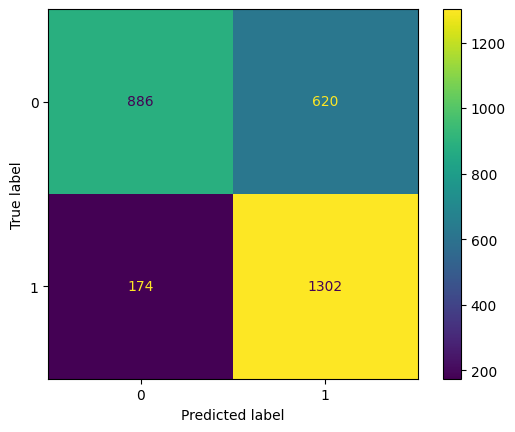

In [18]:
pipeline = Pipeline([
    ('selector', SelectKBest(mutual_info_fixed, k=7)),
    ('knn', KNeighborsClassifier(n_neighbors=clf.best_params_['knn__n_neighbors'], 
                                weights=clf.best_params_['knn__weights'],
                                metric=clf.best_params_['knn__metric'],
                                p=clf.best_params_['knn__p']))
])
# We use the train set to train the model
pipeline.fit(X_train, y_train)

# Obtain the predicted probabilities for the test set
y_test_proba = pipeline.predict_proba(X_test)
y_test_scores = y_test_proba[:, 1]  

# Apply the best threshold (calculated from training data) to the test set
y_test_pred_best = (y_test_scores >= best_threshold).astype(int)

print("=== FINAL EVALUATION ON TEST SET ===")
print(f"Optimal threshold used: {best_threshold:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred_best)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_best))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred_best)).plot()

f1 = f1_score(y_test, y_test_pred_best)
print(f"\nF1-score on test set: {f1:.4f}")